In [1]:
import networkx as nx
from qiskit import QuantumCircuit, Aer, execute
from qiskit.circuit import Parameter
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram
from BA import BA
from PSO import PSO
from ACO import ACO
from ABC import ABC
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi 
import time
import qiskit.quantum_info as qi

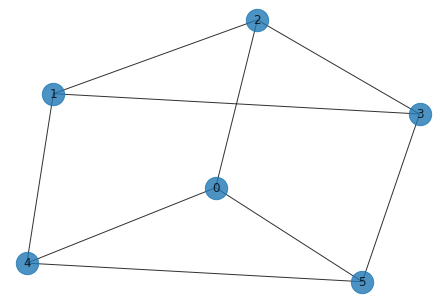

In [2]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, 2), (0, 4), (0, 5), (1,3), (1,2), (1,4), (2,3), (3,5), (4,5)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

In [3]:
'''
Class MaxCutSolver.
A class that is commited to solve a max cut instance problem.
'''
class MaxCutSolver():
        
    '''
    The constructor of the class.
    Params: 
        - graph: The graph of which we want the max cut.
        - num_qubits: The number of qubits needed.
        - backend: The back for running the experiments.
        - p (optinal): The p value for the QAOA
    '''
    def __init__(self, graph, num_qubits, backend, p = 1):
        self.graph = graph
        self.numqubits = num_qubits
        self.circuit = QuantumCircuit(num_qubits)
        self.backend = backend
        self.p = p
        for i in range(0,  self.numqubits):
            self.circuit.h(i)
        gamma = [Parameter("gamma" + str(i)) for i in range(0,p)]
        beta = [Parameter("beta" + str(i)) for i in range(0,p)]
        for j in range(0, p):
            for nodes in list(graph.edges()): 
                self.circuit.rzz(2 * gamma[j], nodes[0], nodes[1])
            for i in range(0,  self.numqubits):
                self.circuit.rx(2 * beta[j], i)

    '''
    Method to get the cost of a cut.
    Params: 
        - bitstring: The cut of the graph.
    Returns:
        - float: the cost of the cut
    '''
    def get_cost_graph(self, bitstring):
        cost = 0
        for i, j in self.graph.edges():
            if bitstring[i] != bitstring[j]:
                cost -= 1
        return cost

    '''
    Method that applies a measurement and executes the class circuit 
    using the parameters passed as a parameter.
    Params: 
        - params: a list that contains the parameters
        for the circuit.
    Returns:
        - dict: a python dict that contains the counts of 
        the execution.
    '''
    def output_circuit(self, params):
        backend = Aer.get_backend(self.backend)
        backend.shots = 1000
        qc_res = self.circuit.copy()
        qc_res = qc_res.bind_parameters(params)
        if (self.backend == 'statevector_simulator'):
            result = qi.Statevector.from_instruction(qc_res).probabilities_dict()
            return result
        else:
            qc_res.measure_all()
            counts = backend.run(qc_res).result().get_counts()
            return counts

    '''
    Method that gets the average value of the execution
    of the class circuit.
    Params: 
        - params: a list that contains the parameters
        for the circuit.
    Returns:
        - float: the average value of the excution.
    '''
    def get_expectation(self, params):
        backend = Aer.get_backend(self.backend)
        qc = self.circuit.copy()
        qc = qc.bind_parameters(params)

        if (self.backend == 'qasm_simulator'):
            qc.measure_all()
            counts = execute(qc, nshots=1000, backend=backend).result().get_counts()
        else:
            counts = qi.Statevector.from_instruction(qc).probabilities_dict()
        avg = 0
        sum_count = 0
        for bitstring, count in counts.items():
            obj = self.get_cost_graph(bitstring)
            avg += obj * count
            sum_count += count
        return avg/sum_count
        
    '''
    Method that gets the optimal values for the parameters
    of the class circuit using the COBYLA optimizer.
    Params: 
        - init_point: the initial point for the cobyla
        optimizer.
    Returns:
        - list: a python list that contains the optimal values.
    '''
    def optimize_classic(self, method, init_point = None):
        #def first_guess_linear(n):
        #    theta = [random.uniform(0, pi) for _ in range(0,n)] + [random.uniform(0, 2*pi) for _ in range(0,n)]
        #    return (theta)
        def first_guess_linear(p,m1=0.5,m2=0.5):
            theta=np.zeros([2*p])
            for i in range(2*p):
                if i % 2 ==0:
                    theta[i]=m1*(i+1)/(2*p)
                else:
                    theta[i]=m2*(2*p-i)/(2*p)
            return(theta)
        def x_ungerade(i,p):# for odd angles (gamma's)
            return (i+0.5)/p
            #return (i+0.25)/(p-0.75)   # unclear what is the best choice for x_i
        def x_gerade(i,p): # for even angles (beta's)
            return (i+0.5)/p
            #return i/p  # unclear what is the best choice for x_i
        def extrapolate(theta):
            p=len(theta)//2+1
            if p<=2: # Extrapolation only makes sense for p>2. Otherwise, take linear guess
                return(first_guess_linear(p))
            else:
                theta2=np.zeros([2*p])
                for i in range(2*p):
                    if i % 2 == 0:
                        x_func = x_ungerade
                        j=0
                    else:
                        x_func = x_gerade
                        j=1
                    x=x_func(i//2,p)
                    while x_func(j//2 +1,p-1)<x:
                        j+=2
                    while j//2>p-3:
                        j-=2
                    x1=x_func(j//2,p-1)
                    x2=x_func(j//2+1,p-1)
                    y1=theta[j]
                    y2=theta[j+2]
                    theta2[i]=((y1-y2)*x+x1*y2-y1*x2)/(x1-x2)
                    i+=1
            return(theta2)
        expectation = self.get_expectation
        if(not init_point):
            theta=[]
            for _ in range(1,self.p+1):
                theta = extrapolate(theta)
            init_point = theta
            print(init_point)
        res = minimize(expectation, init_point, method=method)
        return res

    '''
    Method that gets the optimal values for the parameters
    of the class circuit using the PSO optimizer.
    Params: 
        - interval: the interval to initialize each coordinate of the initial point
        of the particles.
        - dimentions: the number of parameters for the optimizer to optimize.
    Returns:
        - list: a python list that contains the optimal values.
    '''
    def optimize_swarm(self, interval):
        expectation = self.get_expectation
        pso =  PSO(num_particles=20, num_params=self.p*2, interval=interval, function=expectation)
        return pso.run(w=0.4,c1=0.1,c2=0.1, num_iterations=50)


    '''
    Method that gets the optimal values for the parameters
    of the class circuit using the PSO optimizer.
    Params: 
        - interval: the interval to initialize each coordinate of the initial point
        of the particles.
        - dimentions: the number of parameters for the optimizer to optimize.
    Returns:
        - list: a python list that contains the optimal values.
    '''
    def optimize_bees(self, interval):
        expectation = self.get_expectation
        abc =  ABC(dimention=self.p*2, num_points=30, bonds=interval, numlookers=15, fx=expectation)
        return abc.run(num_iterations=50, limit=15, a=pi)


    '''
    Method that gets the optimal values for the parameters
    of the class circuit using the BA optimizer.
    Params: 
        - interval: the interval to initialize each coordinate of the initial point
        of the bats.
        - dimentions: the number of parameters for the optimizer to optimize.
    Returns:
        - list: a python list that contains the optimal values.
    '''
    def optimize_bats(self, interval):
        expectation = self.get_expectation
        ba = BA(number_of_bats=20, num_dimentions=self.p*2, interval=interval, number_of_iterations=50, alfa= 0.9, gamma=0.9)
        return ba.run(expectation)

    '''
    Method that gets the optimal values for the parameters
    of the class circuit using the ACO optimizer.
    Params: 
        - interval: the interval to initialize each coordinate of the initial point
        of the ants.
        - dimentions: the number of parameters for the optimizer to optimize.
    Returns:
        - list: a python list that contains the optimal values.
    '''
    def optimize_ants(self, interval):
        expectation = self.get_expectation
        aco = ACO(num_params=self.p*2,discrete_points=200,interval=interval,
        number_ants=20,q=0.5, evaporation_rate=0.9, num_iterations = 10)
        return aco.run(expectation)
        

# Statevector simulator tests

In [15]:
myanzats = MaxCutSolver(graph=G, num_qubits=6, backend='statevector_simulator',p=6)

### Using gradient descent

In [25]:
result = myanzats.optimize_classic("COBYLA").x

[0.04166667 0.45833333 0.125      0.375      0.20833333 0.29166667
 0.29166667 0.20833333 0.375      0.125      0.45833333 0.04166667]


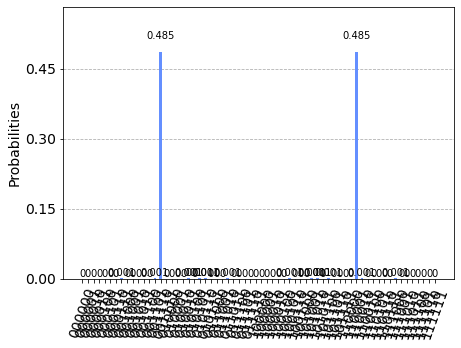

In [26]:
plot_histogram(myanzats.output_circuit(result))

### Using swarm particle optimization

In [27]:
result = myanzats.optimize_swarm([-5,5])
print(result)

[3.30416419 2.85428288 1.45545383 3.59496193 0.58076379 2.18819844
 4.58657369 1.08606456 3.22405128 0.68920631 4.30738362 4.13824107]


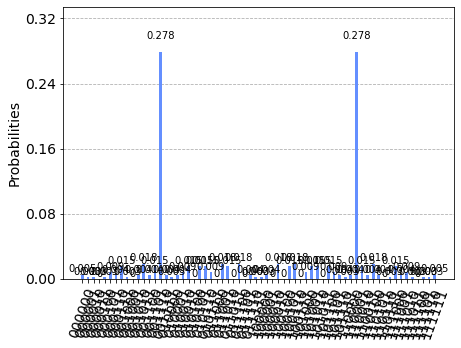

In [28]:
plot_histogram(myanzats.output_circuit(result))

### Using bat optimization

In [9]:
result = myanzats.optimize_bats([-5,5])
print(result)

[ 2.52000518e+45  1.24236548e+45 -3.11087181e+44  2.88158594e+45
  2.28038038e+45  3.49646583e+45  2.69517040e+45 -2.36425150e+44
 -1.85126566e+44  8.31617142e+44 -4.33777929e+45 -1.85238767e+44]


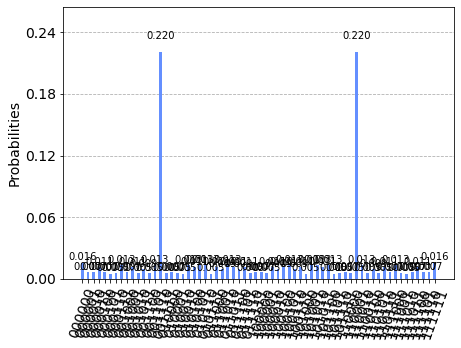

In [10]:
plot_histogram(myanzats.output_circuit(result))

### Using artificial bee colony

In [7]:
result = myanzats.optimize_bees([0,2*pi])
print(result)

[32154.44094542 32155.70320774 32156.9568607  32151.8482091
 32157.19807748 32156.35521001 32155.20324423 32157.66977244
 32153.41803143 32153.05854634 32151.48454555 32155.95495266]


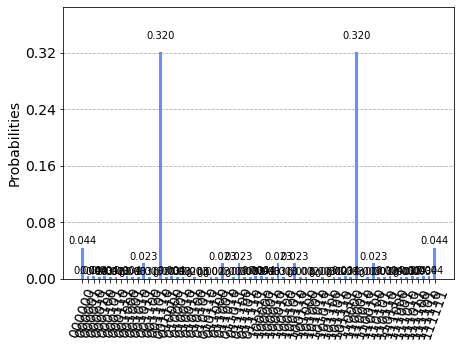

In [8]:
plot_histogram(myanzats.output_circuit(result))

### Using ant colony optimization

In [16]:
result, iter_ants = myanzats.optimize_ants([-5,5])
print(result)

iteration 0 with cost of -4.9891481944679645
[8.018735438517748, 7.64674938675811, 7.058841165414311, 3.6388004440584387, 0.5364693056461527, 2.795110745544352, 2.860279636715396, 0.2502630998154436, 2.6773951683075414, 1.0642827655217981, 1.3376883669101602, 1.535252692986162]


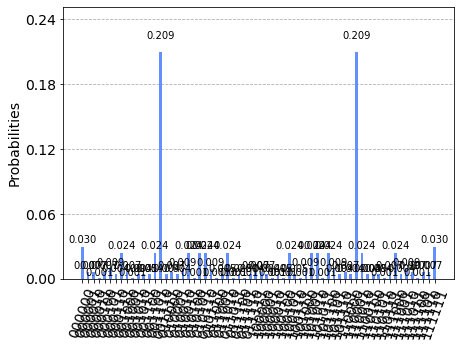

In [17]:
plot_histogram(myanzats.output_circuit(result))

# Qasm simulator tests

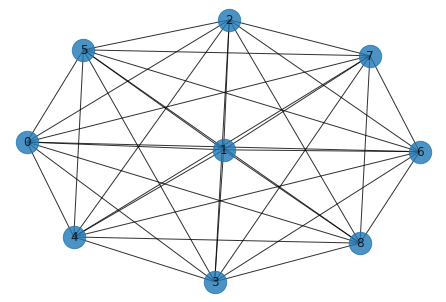

In [4]:
G = nx.generators.classic.complete_graph(9)
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

In [14]:
myanzats = MaxCutSolver(graph=G, num_qubits=9, backend='qasm_simulator', p=1)

### Using gradient optimization

In [15]:
result = myanzats.optimize_classic("COBYLA")

[0.25 0.25]


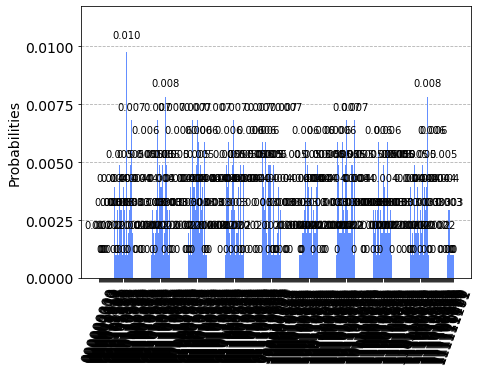

In [18]:
plot_histogram(myanzats.output_circuit(result.x))

### Using particle swarm optimization

In [19]:
myanzats.optimize_swarm([-5,5])

array([0.61188326, 2.17823064, 0.70071774, 2.16224837, 4.45029267,
       6.54765522])

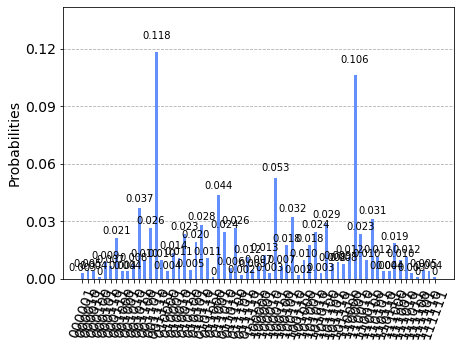

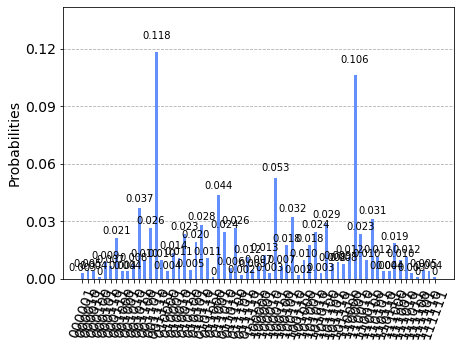

In [20]:
plot_histogram(myanzats.output_circuit([0.61188326, 2.17823064, 0.70071774, 2.16224837, 4.45029267,
       6.54765522]))

### Using bat optimization

In [21]:
result = myanzats.optimize_bats([-5,5])

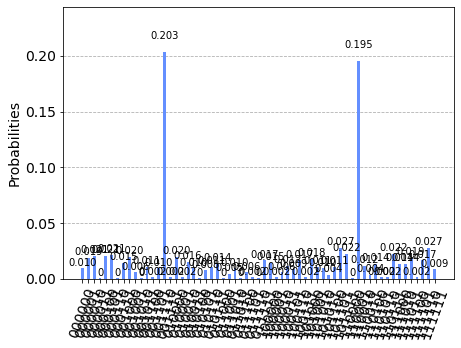

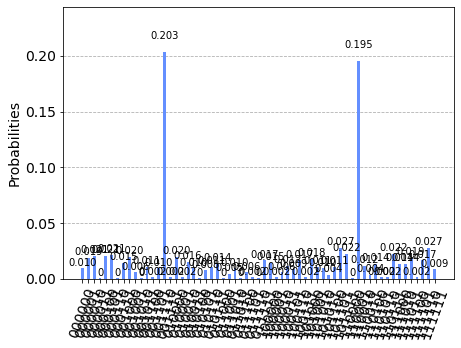

In [22]:
plot_histogram(myanzats.output_circuit(result))

### Using ant colony optimization

In [23]:
result,iter_ants = myanzats.optimize_ants([-5,5])

solution found


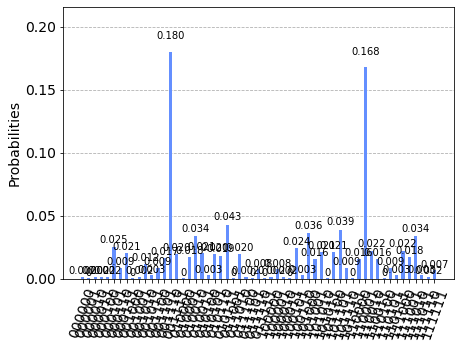

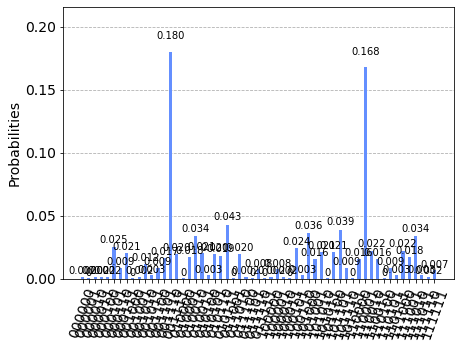

In [24]:
plot_histogram(myanzats.output_circuit(result))

# Comparison between the optimizers

## Statevector simulator

In [18]:
gradient_values_nm_p = list()
gradient_values_cobyla_p = list()
gradient_values_slsqp_p = list()
swarm_values_p = list()
bats_values_p = list()
ants_values_p = list() 
bees_values_p = list()
gradient_values_nm = list()
gradient_values_cobyla = list()
gradient_values_slsqp = list()
swarm_values = list()
bats_values = list()
ants_values = list()
bees_values = list()
gradient_time_nm = list()
gradient_time_cobyla = list()
gradient_time_slsqp = list()
swarm_time = list()
bats_time = list()
ants_time = list()
bees_time = list()
gradient_iterations_nm = list()
gradient_iterations_cobyla = list()
gradient_iterations_slsqp = list()
swarm_iterations = list()
bats_iterations = list()
ants_iterations = list()
bees_iterations = list()
p_range = 8
for i in range(1, p_range):
    myanzats = MaxCutSolver(graph=G, num_qubits=6, backend='statevector_simulator', p=i)
    start_time = time.time()
    opt_nm = myanzats.optimize_classic(method='Nelder-Mead')
    gradient_dict_nm = myanzats.output_circuit(opt_nm.x)
    gradient_time_nm.append(time.time() - start_time)
    start_time = time.time()
    opt_cobyla = myanzats.optimize_classic(method='COBYLA')
    gradient_dict_cobyla = myanzats.output_circuit(opt_cobyla.x)
    gradient_time_cobyla.append(time.time() - start_time)
    start_time = time.time()
    opt_slsqp = myanzats.optimize_classic(method='SLSQP')
    gradient_dict_slsqp = myanzats.output_circuit(opt_slsqp.x)
    gradient_time_slsqp.append(time.time() - start_time)
    start_time = time.time()
    swarm_dict = myanzats.output_circuit(myanzats.optimize_swarm([0,pi]))
    swarm_time.append(time.time() - start_time)
    start_time = time.time()
    bats_dict = myanzats.output_circuit(myanzats.optimize_bats([0,pi]))
    bats_time.append(time.time() - start_time)
    start_time = time.time()
    opt_ants,iter_ants = myanzats.optimize_ants([0,pi])
    ants_dict = myanzats.output_circuit(opt_ants)
    ants_time.append(time.time() - start_time)

    print("empezando abejas")
    start_time = time.time()
    opt_bees = myanzats.optimize_bees([0,2*pi])
    bees_dict = myanzats.output_circuit(opt_bees)
    bees_time.append(time.time() - start_time)

    bats_values_p.append(bats_dict['110001']/max(bats_dict.values()))
    swarm_values_p.append(swarm_dict['110001']/max(swarm_dict.values()))
    gradient_values_nm_p.append(gradient_dict_nm['110001']/max(gradient_dict_nm.values()))
    gradient_values_cobyla_p.append(gradient_dict_cobyla['110001']/max(gradient_dict_cobyla.values()))
    gradient_values_slsqp_p.append(gradient_dict_slsqp['110001']/max(gradient_dict_slsqp.values()))
    ants_values_p.append(ants_dict['110001']/max(ants_dict.values()))
    bees_values_p.append(bees_dict['110001']/max(bees_dict.values()))
    bats_values.append(bats_dict['110001'])
    swarm_values.append(swarm_dict['110001'])
    gradient_values_nm.append(gradient_dict_nm['110001'])
    gradient_values_cobyla.append(gradient_dict_cobyla['110001'])
    gradient_values_slsqp.append(gradient_dict_slsqp['110001'])
    ants_values.append(ants_dict['110001'])
    bees_values.append(bees_dict['110001'])
    gradient_iterations_nm.append(opt_nm.nit)
    #gradient_iterations_cobyla.append(opt_cobyla.nit)
    gradient_iterations_slsqp.append(opt_slsqp.nit)
    swarm_iterations.append(100)
    bats_iterations.append(50)
    bees_iterations.append(30)
    ants_iterations.append(iter_ants)

[0.25 0.25]
[0.25 0.25]
[0.25 0.25]
iteration 0 with cost of -5.041192644454018
empezando abejas
[0.125 0.375 0.375 0.125]
[0.125 0.375 0.375 0.125]
[0.125 0.375 0.375 0.125]
iteration 0 with cost of -4.761650464508141
empezando abejas
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
iteration 0 with cost of -4.89651916338658
empezando abejas
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
iteration 0 with cost of -4.708489268818952
empezando abejas
[0.05 0.45 0.15 0.35 0.25 0.25 0.35 0.15 0.45 0.05]
[0.05 0.45 0.15 0.35 0.25 0.25 0.35 0.15 0.45 0.05]
[0.05 0.45 0.15 0.35 0.25 0.25 0.35 0.15 0.45 0.05]
iteration 0 with cost of -4.991325273887977
empezando abejas
[0.04166667 0.45833333 0.125      0.375      0.2

### Approximation ratio vs p-value

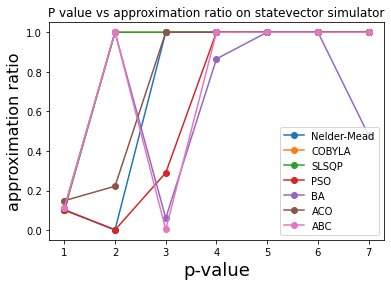

In [19]:
plt.plot(list(range(1,p_range)), gradient_values_nm_p, '-o')
plt.plot(list(range(1,p_range)), gradient_values_cobyla_p, '-o')
plt.plot(list(range(1,p_range)), gradient_values_slsqp_p, '-o')
plt.plot(list(range(1,p_range)), swarm_values_p, '-o')
plt.plot(list(range(1,p_range)), bats_values_p, '-o')
plt.plot(list(range(1,p_range)), ants_values_p, '-o')
plt.plot(list(range(1,p_range)), bees_values_p, '-o')
plt.legend(["Nelder-Mead", "COBYLA","SLSQP","PSO", "BA", "ACO","ABC"])
plt.title("P value vs approximation ratio on statevector simulator")
plt.xlabel('p-value', fontsize=18)
plt.ylabel('approximation ratio', fontsize=16)
plt.show()

### Ground state probability vs p-value

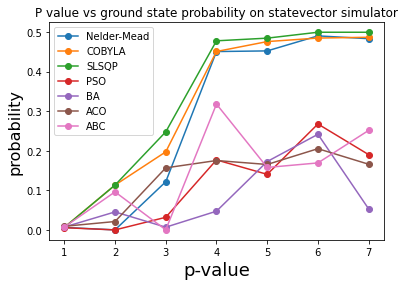

In [20]:
plt.plot(list(range(1,p_range)), gradient_values_nm, '-o')
plt.plot(list(range(1,p_range)), gradient_values_cobyla, '-o')
plt.plot(list(range(1,p_range)), gradient_values_slsqp, '-o')
plt.plot(list(range(1,p_range)), swarm_values, '-o')
plt.plot(list(range(1,p_range)), bats_values, '-o')
plt.plot(list(range(1,p_range)), ants_values, '-o')
plt.plot(list(range(1,p_range)), bees_values, '-o')
plt.legend(["Nelder-Mead", "COBYLA","SLSQP","PSO", "BA", "ACO", "ABC"])
plt.title("P value vs ground state probability on statevector simulator")
plt.xlabel('p-value', fontsize=18)
plt.ylabel('probability', fontsize=16)
plt.show()

### Execution time

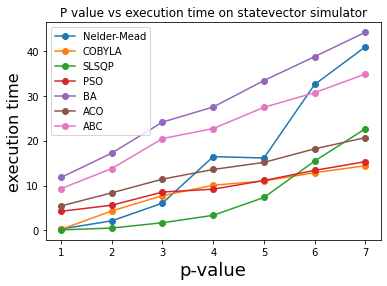

In [21]:
plt.plot(list(range(1,p_range)), gradient_time_nm, '-o')
plt.plot(list(range(1,p_range)), gradient_time_cobyla, '-o')
plt.plot(list(range(1,p_range)), gradient_time_slsqp, '-o')
plt.plot(list(range(1,p_range)), swarm_time, '-o')
plt.plot(list(range(1,p_range)), bats_time, '-o')
plt.plot(list(range(1,p_range)), ants_time, '-o')
plt.plot(list(range(1,p_range)), bees_time, '-o')
plt.legend(["Nelder-Mead", "COBYLA","SLSQP","PSO", "BA", "ACO", "ABC"])
plt.title("P value vs execution time on statevector simulator")
plt.xlabel('p-value', fontsize=18)
plt.ylabel('execution time', fontsize=16)
plt.show()

## Qasm simulator

In [23]:
gradient_values_nm_p = list()
gradient_values_cobyla_p = list()
gradient_values_slsqp_p = list()
swarm_values_p = list()
bats_values_p = list()
ants_values_p = list()
bees_values_p = list()
gradient_values_nm = list()
gradient_values_cobyla = list()
gradient_values_slsqp = list()
swarm_values = list()
bats_values = list()
ants_values = list()
bees_values = list()
gradient_time_nm = list()
gradient_time_cobyla = list()
gradient_time_slsqp = list()
swarm_time = list()
bats_time = list()
ants_time = list()
bees_time = list()
gradient_iterations_nm = list()
gradient_iterations_cobyla = list()
gradient_iterations_slsqp = list()
swarm_iterations = list()
bats_iterations = list()
ants_iterations = list()
bees_iterations = list()
p_range = 8
for i in range(1, p_range):
    myanzats = MaxCutSolver(graph=G, num_qubits=6, backend='qasm_simulator', p=i)
    start_time = time.time()
    opt_gradient_nm = myanzats.optimize_classic(method='Nelder-Mead')
    gradient_time_nm.append(time.time() - start_time)
    start_time = time.time()
    opt_gradient_cobyla = myanzats.optimize_classic(method='COBYLA').x
    gradient_time_cobyla.append(time.time() - start_time)
    start_time = time.time()
    opt_gradient_slsqp = myanzats.optimize_classic(method='SLSQP')
    gradient_time_slsqp.append(time.time() - start_time)
    start_time = time.time()
    opt_bats = myanzats.optimize_bats([0,pi])
    bats_time.append(time.time() - start_time )
    start_time = time.time()
    opt_ants,iter_ants = myanzats.optimize_ants([-5,5])
    ants_time.append(time.time() - start_time)
    start_time = time.time()
    opt_swarm = myanzats.optimize_swarm([-5,5])
    swarm_time.append(time.time() - start_time)
    start_time = time.time()
    opt_bee = myanzats.optimize_bees([0,2*pi])
    bees_time.append(time.time() - start_time)


    gradient_iterations_nm.append(opt_gradient_nm.nit)
    gradient_iterations_slsqp.append(opt_gradient_slsqp.nit)
    opt_gradient_nm = myanzats.optimize_classic(method='Nelder-Mead').x
    opt_gradient_slsqp = myanzats.optimize_classic(method='SLSQP').x
    
    swarm_iterations.append(100)
    bats_iterations.append(50)
    ants_iterations.append(iter_ants)
    bees_iterations.append(10)
    mean_gradient_p_nm = 0
    mean_gradient_p_cobyla = 0
    mean_gradient_p_slsqp = 0
    mean_ants_p = 0
    mean_bats_p = 0
    mean_swarm_p = 0
    mean_bees_p = 0
    mean_gradient_nm = 0
    mean_gradient_cobyla = 0
    mean_gradient_slsqp = 0
    mean_ants = 0
    mean_bats = 0
    mean_swarm = 0
    mean_bees = 0

    for i in range(0,30):

        gradient_dict_nm = myanzats.output_circuit(opt_gradient_nm)
        gradient_dict_cobyla = myanzats.output_circuit(opt_gradient_cobyla)
        gradient_dict_slsqp = myanzats.output_circuit(opt_gradient_slsqp)
        swarm_dict = myanzats.output_circuit(opt_swarm)
        bats_dict = myanzats.output_circuit(opt_bats)
        ants_dict = myanzats.output_circuit(opt_ants)
        bees_dict = myanzats.output_circuit(opt_bee)

        mean_bats_p = 0 if not '110001' in bats_dict else bats_dict['110001']/max(bats_dict.values())
        mean_swarm_p = 0 if not '110001' in swarm_dict else swarm_dict['110001']/max(swarm_dict.values())
        mean_gradient_p_nm = 0 if not '110001' in gradient_dict_nm else gradient_dict_nm['110001']/max(gradient_dict_nm.values())
        mean_gradient_p_cobyla = 0 if not '110001' in gradient_dict_cobyla else gradient_dict_cobyla['110001']/max(gradient_dict_cobyla.values())
        mean_gradient_p_slsqp = 0 if not '110001' in gradient_dict_slsqp else gradient_dict_slsqp['110001']/max(gradient_dict_slsqp.values())
        mean_ants_p = 0 if not '110001' in ants_dict else ants_dict['110001']/max(ants_dict.values())
        mean_bees_p = 0 if not '110001' in bees_dict else bees_dict['110001']/max(bees_dict.values())
        

        mean_gradient_nm += 0 if not '110001' in gradient_dict_nm else gradient_dict_nm['110001']  
        mean_gradient_cobyla += 0 if not '110001' in gradient_dict_cobyla else gradient_dict_cobyla['110001']
        mean_gradient_slsqp += 0 if not '110001' in gradient_dict_slsqp else gradient_dict_slsqp['110001'] 
        mean_swarm += 0 if not '110001' in swarm_dict else swarm_dict['110001'] 
        mean_bats += 0 if not '110001' in bats_dict else bats_dict['110001'] 
        mean_ants += 0 if not '110001' in ants_dict else ants_dict['110001']
        mean_bees += 0 if not '110001' in bees_dict else bees_dict['110001']


    bats_values.append(mean_bats/30)
    swarm_values.append(mean_swarm/30)
    gradient_values_nm.append(mean_gradient_nm/30)
    gradient_values_cobyla.append(mean_gradient_cobyla/30)
    gradient_values_slsqp.append(mean_gradient_slsqp/30)
    ants_values.append(mean_ants/30)
    bees_values.append(mean_bees/30)
    bats_values_p.append(mean_bats_p/30)
    swarm_values_p.append(mean_swarm_p/30)
    gradient_values_nm_p.append(mean_gradient_p_nm/30)
    gradient_values_cobyla_p.append(mean_gradient_p_cobyla/30)
    gradient_values_slsqp_p.append(mean_gradient_p_slsqp/30)
    ants_values_p.append(mean_ants_p/30)
    bees_values_p.append(mean_bees_p/30)

[0.25 0.25]
[0.25 0.25]
[0.25 0.25]
iteration 0 with cost of -5.0537109375
[0.25 0.25]
[0.25 0.25]
[0.125 0.375 0.375 0.125]
[0.125 0.375 0.375 0.125]
[0.125 0.375 0.375 0.125]
iteration 0 with cost of -4.83984375
[0.125 0.375 0.375 0.125]
[0.125 0.375 0.375 0.125]
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
iteration 0 with cost of -5.1484375
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
[0.08333333 0.41666667 0.25       0.25       0.41666667 0.08333333]
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
iteration 0 with cost of -5.3056640625
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
[0.0625 0.4375 0.1875 0.3125 0.3125 0.1875 0.4375 0.0625]
[0.05 0.45 0.15 0.35 0.25 0.2

### Approximation ratio vs p-value

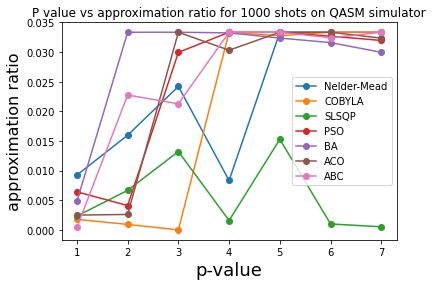

In [24]:
plt.plot(list(range(1,p_range)), gradient_values_nm_p, '-o')
plt.plot(list(range(1,p_range)), gradient_values_cobyla_p, '-o')
plt.plot(list(range(1,p_range)), gradient_values_slsqp_p, '-o')
plt.plot(list(range(1,p_range)), swarm_values_p, '-o')
plt.plot(list(range(1,p_range)), bats_values_p, '-o')
plt.plot(list(range(1,p_range)), ants_values_p, '-o')
plt.plot(list(range(1,p_range)), bees_values_p, '-o')
plt.legend(["Nelder-Mead", "COBYLA","SLSQP","PSO", "BA", "ACO", "ABC"])
plt.title("P value vs approximation ratio for 1000 shots on QASM simulator")
plt.xlabel('p-value', fontsize=18)
plt.ylabel('approximation ratio', fontsize=16)
plt.show()

### Ground state probability vs p-value

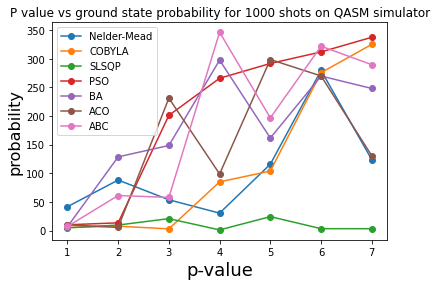

In [25]:
plt.plot(list(range(1,p_range)), gradient_values_nm, '-o')
plt.plot(list(range(1,p_range)), gradient_values_cobyla, '-o')
plt.plot(list(range(1,p_range)), gradient_values_slsqp, '-o')
plt.plot(list(range(1,p_range)), swarm_values, '-o')
plt.plot(list(range(1,p_range)), bats_values, '-o')
plt.plot(list(range(1,p_range)), ants_values, '-o')
plt.plot(list(range(1,p_range)), bees_values, '-o')
plt.legend(["Nelder-Mead", "COBYLA","SLSQP","PSO", "BA", "ACO","ABC"])
plt.title("P value vs ground state probability for 1000 shots on QASM simulator")
plt.xlabel('p-value', fontsize=18)
plt.ylabel('probability', fontsize=16)
plt.show()

### Execution time vs p-value

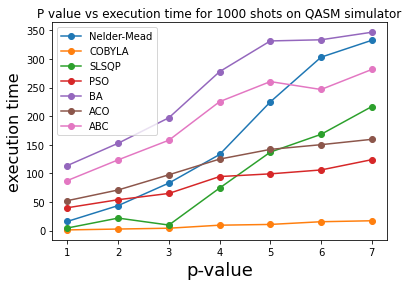

In [26]:
plt.plot(list(range(1,p_range)), gradient_time_nm, '-o')
plt.plot(list(range(1,p_range)), gradient_time_cobyla, '-o')
plt.plot(list(range(1,p_range)), gradient_time_slsqp, '-o')
plt.plot(list(range(1,p_range)), swarm_time, '-o')
plt.plot(list(range(1,p_range)), bats_time, '-o')
plt.plot(list(range(1,p_range)), ants_time, '-o')
plt.plot(list(range(1,p_range)), bees_time, '-o')
plt.legend(["Nelder-Mead", "COBYLA","SLSQP","PSO", "BA", "ACO", "ABC"])
plt.title("P value vs execution time for 1000 shots on QASM simulator")
plt.xlabel('p-value', fontsize=18)
plt.ylabel('execution time', fontsize=16)
plt.show()